<a href="https://colab.research.google.com/github/brighamfrandsen/econ484/blob/master/tweet%20demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/brighamfrandsen/econ484/blob/master/examples/tweet%20demo.ipynb)



First some preliminaries. Import some useful packages:

In [ ]:
import json
import re

import joblib
import pandas as pd
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree
import pydotplus
from mlxtend.plotting import plot_decision_regions
from matplotlib import pyplot as plt


To be able to display things in the notebook:

In [ ]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display

    more prelims

In [ ]:
# constants
SEED = 123
TEST_SIZE = .05  # the proportion of data left out of sample
# MAX_FEATURES = 7500 # the maximum number of bag of words features
N_JOBS = 11  # the number of threads to be used during training, -1 uses all processors available
DEPTH = 3  # the depth of visualization of decision tree
SVM_FEATS = 1000

Read in raw data

In [ ]:
# reading in the data
obama = pd.read_csv('/content/gdrive/My Drive/Econ 484/datasets/obama_tweets.csv')
trump = pd.DataFrame(json.load(open('/content/gdrive/My Drive/Econ 484/datasets/trump_tweets.json',encoding='utf8')))

print(obama.head())
print(trump.head())

                                                Text                 Date  \
0  My heart goes out to the victims and their fam...  2017-03-23 06:00:20   
1  Chuck Berry rolled over everyone who came befo...  2017-03-19 08:51:23   
2  On International Women’s Day, @MichelleObama a...  2017-03-08 13:14:58   
3  Humbled to be recognized by a family with a le...  2017-03-02 07:22:07   
4  We asked. You answered.https://medium.com/@Oba...  2017-02-17 11:37:55   

   Favorites  Retweets            Tweet ID  
0     489842     95567  844896595179180034  
1     377691     65990  843490091519623169  
2     257782     51078  839585255703080968  
3      97356     17387  837322131834875904  
4     110269     25539  832675462325243906  
                                                text
0  The Wall is going up very fast despite total O...
1  Puerto Rico is one of the most corrupt places ...
2  ....And by the way, I’m the best thing that’s ...
3  Our Federal Reserve cannot “mentally” keep up ...
4 

In [ ]:
# adding obama indicator
obama['obama_indicator'] = 1
trump['obama_indicator'] = 0

some data cleaning

In [ ]:
# Renaming columns to make them consistent for concatenation
obama.rename(columns={'Text': '_text'}, inplace=True)
trump.rename(columns={'text': '_text'}, inplace=True)

# Concatenating the two datasets
both = pd.concat([obama.loc[:, ['_text', 'obama_indicator']],
                  trump.loc[:, ['_text', 'obama_indicator']]])

# Dropping retweets
both = both.loc[~both._text.str.contains('^RT'), :]
print('Shape of raw data:', both.shape)

# Cleaning the text
both['_text'] = both['_text'].str.strip()

# Replace sequences
both['_text'] = both['_text'].replace({
    r'\s+': ' ',                       # Removing extra spaces
    r'(?:: )?https?://\S+': '',         # Removing URLs
    r'\.?pic\.twitter\.com/\S+': '',    # Removing Twitter image links
    r'\d+': '',                         # Removing digits
    r'[…"#$%&\'\(\)*+,-./:;<=>?@\[\\\]^_`{|}~’“”—]': '',  # Removing punctuation
    r'–|––|\s+': ' '                   # Normalizing dashes and extra spaces
}, regex=True)

# Count the number of capital letters before converting to lowercase
both['n_cap_let'] = both['_text'].apply(lambda x: len(re.findall('[A-Z]', x)))

# Converting the text to lowercase
both['_text'] = both['_text'].str.lower()

# Removing specific words related to the context
remove_words = ['trump', 'president obama', 'obama', 'barack', 'michelle', 'amp', 'ofa']
for word in remove_words:
    both['_text'] = both['_text'].str.replace(word, '', regex=False)

# Tokenizing the text
tknzr = TweetTokenizer()
both['tokens'] = both['_text'].apply(lambda x: [re.sub('_', '', y) for y in tknzr.tokenize(x)])

# Dropping rows with empty tokens after cleaning
both = both.loc[both['tokens'].apply(lambda x: len(x) > 0), :]

# Generating feature variables
both['total_words'] = both['tokens'].apply(len)
both['avg_word_len'] = both['tokens'].apply(lambda x: sum(len(y) for y in x) / len(x) if len(x) > 0 else 0)

print("Data cleaned and features generated...")


Shape of raw data: (12681, 2)


<ipython-input-7-7dd57582e271>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both['_text'] = both['_text'].str.strip()


Data cleaned and features generated...


<ipython-input-7-7dd57582e271>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both['total_words'] = both['tokens'].apply(len)
<ipython-input-7-7dd57582e271>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  both['avg_word_len'] = both['tokens'].apply(lambda x: sum(len(y) for y in x) / len(x) if len(x) > 0 else 0)


generate features

In [ ]:
vectorizer = CountVectorizer(max_df=.5, min_df=.0001, stop_words='english', tokenizer=tknzr.tokenize,
                                 ngram_range=(1, 3))
bow_mat = vectorizer.fit_transform(both._text)
print('Bag of words feature set:', bow_mat.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Bag of words feature set: (12565, 26776)


get ready to model

In [ ]:
# modelling
dtree = DecisionTreeClassifier(random_state=SEED,max_depth=5)
dtree.fit(bow_mat, both.obama_indicator)

DecisionTreeClassifier(max_depth=5, random_state=123)

In [ ]:
# visualize decision tree
dot_data = tree.export_graphviz(dtree,  feature_names=vectorizer.get_feature_names_out(),class_names=['Trump','Obama'],filled = True, special_characters=True)
graph = Source(dot_data)

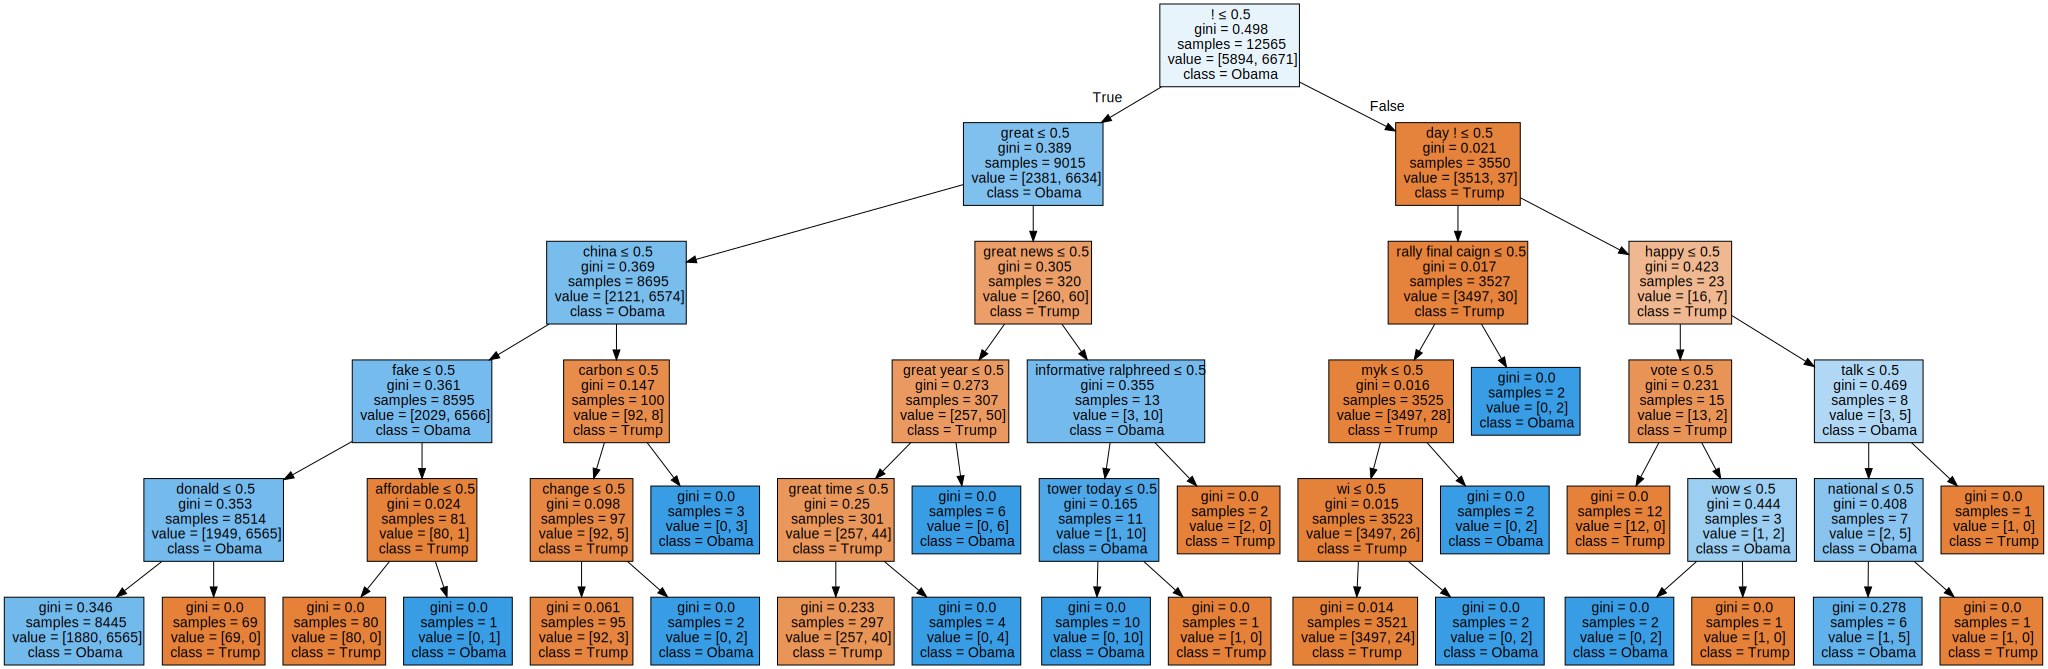

'trumpvobama.pdf'

In [ ]:
display(SVG(graph.pipe(format='svg')))
graph.render('trumpvobama')

Try a new tweet:

In [ ]:
new_tweet='Congrats to our newest class of foundation scholars. These leaders are working to change their communities for the better'
new_feats=vectorizer.transform([new_tweet])
dtree.predict_proba(new_feats)

array([[0.22261693, 0.77738307]])

In [ ]:
print(new_feats)

  (0, 2122)	1
  (0, 3408)	1
  (0, 3816)	1
  (0, 4241)	1
  (0, 4428)	1
  (0, 9020)	1
  (0, 13408)	1
  (0, 16209)	1
  (0, 26225)	1
